In [118]:
from google.cloud import bigquery
import pandas
#!pip install pandas-profiling
import pandas_profiling
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
#!pip install google-cloud-bigquery-storage 
from matplotlib.ticker import FuncFormatter

import seaborn as sns
import numpy as np
from matplotlib.ticker import PercentFormatter


# !pip install plotly
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

In [119]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: w205-287623


In [120]:
# for maps
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

import gmaps
import gmaps.datasets
import gmaps.geojson_geometries

from google.cloud import bigquery
import pandas

gmaps.configure(api_key='') # Fill in with your API key


# EDA - quick look for outliers only

In [5]:
# distribution of trip length
trip_length = """  SELECT
    TIMESTAMP_DIFF(end_date,start_date, MINUTE) AS minutes,
    trip_id
   # COUNT(DISTINCT trip_id) AS trips
  FROM  `bigquery-public-data.san_francisco.bikeshare_trips`
 # GROUP BY 1
;
"""
trip_job = client.query(trip_length) 

trip_df = trip_job.to_dataframe()
trip_df.describe()

,minutes,trip_id
count,983648.000000,9.836480e+05
mean,16.983063,6.721238e+05
std,307.001181,3.851056e+05
min,1.000000,4.069000e+03
25%,6.000000,3.359168e+05
50%,9.000000,6.779755e+05
75%,12.000000,1.001672e+06
max,287899.000000,1.338408e+06


(array([9.83645e+05, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.000000e+00, 2.879080e+04, 5.758060e+04, 8.637040e+04,
        1.151602e+05, 1.439500e+05, 1.727398e+05, 2.015296e+05,
        2.303194e+05, 2.591092e+05, 2.878990e+05]),
 <BarContainer object of 10 artists>)

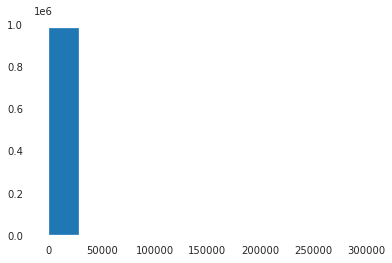

In [6]:
# visualize distribution -- is it normal?
plt.hist(trip_df.minutes)

In [7]:
# nope not normally distributed at first sight. 
# still skewed identify 99th %tile of distribution
print(trip_df.quantile(.99))

minutes        191.00
trip_id    1325046.53
Name: 0.99, dtype: float64


confirm that approximately 99% of trips are 3 or fewer hours: 0.01077926250040665


(array([885029.,  58959.,   9556.,   5434.,   3694.,   3003.,   2447.,
          2007.,   1561.,   1355.]),
 array([  1. ,  18.8,  36.6,  54.4,  72.2,  90. , 107.8, 125.6, 143.4,
        161.2, 179. ]),
 <BarContainer object of 10 artists>)

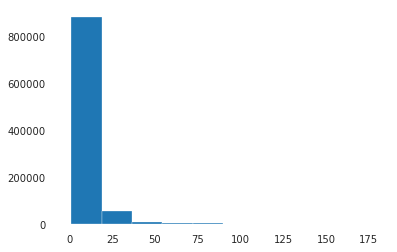

In [8]:
# looks like ~3 hrs or 180 minutes is an outlier
trip_df_clean = trip_df[trip_df.minutes < 180]
print("confirm that approximately 99% of trips are 3 or fewer hours:",(len(trip_df) - len(trip_df_clean))/len(trip_df))

plt.hist(trip_df_clean.minutes)
# slightly better histogram but let's see if there are trips that look too short 

pct of trips greater than 2 minutes: 0.013746787468687986


,minutes,trip_id
count,970126.000000,9.701260e+05
mean,11.673265,6.734019e+05
std,15.023747,3.849540e+05
min,2.000000,4.069000e+03
25%,6.000000,3.374342e+05
50%,9.000000,6.798305e+05
75%,12.000000,1.003036e+06
max,179.000000,1.338408e+06


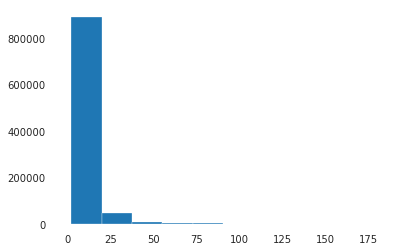

In [9]:
trip_df_clean.describe()
# still need to remove trips with length of time <= 1 minute

trip_df_clean = trip_df_clean[trip_df_clean.minutes >= 2]
print("pct of trips greater than 2 minutes:",(len(trip_df) - len(trip_df_clean))/len(trip_df)) #confirm 

plt.hist(trip_df_clean.minutes)
trip_df_clean.describe()
# not a normal distribution remove trips greater than 3 hrs and less than 2 minutes 

# Required Questions

## What are the 5 most popular trips that you would call "commuter trips"? 

Caveats and assumptions:
* SF commute hours set at 6am to 10am and 4pm to 8pm. Consider only weekdays. 
* Sunday as the first day of the week.
* Do not remove holidays
* Not restricting to subscribers


In [10]:
top_commuter_trips = """ WITH 
   TRIP_COUNTS AS (
   --breakout and then combine top morning and evening trips 
   --useful for future analyses. Could be done in a single query here. 
  
     SELECT 
       start_station_name, 
       end_station_name,
       'morning' AS commute_block,    
       COUNT(DISTINCT IF (EXTRACT(HOUR FROM start_date) BETWEEN 6 and 9, trip_id, NULL)) AS trips
     FROM `bigquery-public-data.san_francisco.bikeshare_trips`
     WHERE 
       EXTRACT(DAYOFWEEK FROM DATE(start_date)) NOT IN (1,7) # exclude Sunday and Saturday
       AND TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 2 AND 180
       AND start_station_name <> end_station_name
     GROUP BY 1,2,3
    
     UNION ALL
    
     SELECT 
       start_station_name, 
       end_station_name,
       'evening' AS commute_block,  
        COUNT(DISTINCT IF (EXTRACT(HOUR FROM start_date) BETWEEN 16 and 19, trip_id, NULL)) AS trips
     FROM `bigquery-public-data.san_francisco.bikeshare_trips`
     WHERE 
       EXTRACT(DAYOFWEEK FROM DATE(start_date)) NOT IN (1,7) # exclude Sunday and Saturday
       AND TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 2 AND 180
       AND start_station_name <> end_station_name
     GROUP BY 1,2,3
 )

 SELECT
   *
 FROM TRIP_COUNTS
 ORDER BY trips DESC
 LIMIT 5
;
"""

top_commuter_trips_job = client.query(top_commuter_trips) 

top_commuter_trips_df = top_commuter_trips_job.to_dataframe()
top_commuter_trips_df

,start_station_name,end_station_name,commute_block,trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,morning,4795
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),evening,4329
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),evening,4131
3,Embarcadero at Sansome,Steuart at Market,evening,4105
4,Steuart at Market,2nd at Townsend,morning,3815


## Check if events in bikeshare_status table have discrepancies

In [11]:
# return records where there has been a status change
bikeshare_status_query = """ 
WITH 
   CHANGE AS (
     SELECT 
       station_id,
       bikes_available,
       docks_available,
       time,
       lag(bikes_available) OVER (PARTITION BY station_id ORDER BY time) AS last_bikes_available,
       lag(docks_available) OVER (PARTITION BY station_id ORDER BY time) AS last_docks_available
     FROM  `bigquery-public-data.san_francisco.bikeshare_status`
 ),
   AGG AS (
     SELECT 
       station_id,
       bikes_available,
       time, 
       docks_available,
       lag(time) OVER (PARTITION BY station_id ORDER BY time) AS last_time,
       last_bikes_available - bikes_available AS change_bikes_available,
       last_docks_available - docks_available AS change_docks_available
     FROM CHANGE
     WHERE (bikes_available <> last_bikes_available 
       OR docks_available <> last_docks_available)
   )
 SELECT
   FORMAT_DATE("%A" , DATE(last_time)) AS day_of_week,
   TIMESTAMP_DIFF(last_time, time, MINUTE) AS minutes_since_last_change,
   time, 
   station_id,
   bikes_available, 
   docks_available,
   change_bikes_available,
   change_docks_available,
   change_bikes_available != -change_docks_available AS discrepancy
 FROM AGG
;
"""

bikeshare_status_job = client.query(bikeshare_status_query) 

bikeshare_status_df = bikeshare_status_job.to_dataframe()
bikeshare_status_df


,day_of_week,minutes_since_last_change,time,station_id,bikes_available,docks_available,change_bikes_available,change_docks_available,discrepancy
0,Sunday,-16.0,2013-09-15 15:01:02+00:00,72,23,0,-1,1,False
1,Friday,-27.0,2013-09-20 21:00:01+00:00,72,23,0,-2,2,False
2,Thursday,-13.0,2013-10-10 18:16:01+00:00,72,23,0,-1,1,False
3,Thursday,-14.0,2013-10-10 20:54:02+00:00,72,23,0,-1,1,False
4,Tuesday,0.0,2013-10-15 20:22:01+00:00,72,23,0,-1,1,False
...,...,...,...,...,...,...,...,...,...
3008081,Wednesday,0.0,2016-08-31 18:15:59+00:00,69,22,1,-1,1,False
3008082,Wednesday,-2.0,2016-08-31 18:19:01+00:00,69,22,1,-1,1,False
3008083,Wednesday,-1.0,2016-08-31 18:22:00+00:00,69,22,1,-1,1,False
3008084,Wednesday,-11.0,2016-08-31 18:47:52+00:00,69,22,1,-1,0,True


In [12]:
# there are discrepancies in the number of bikes and docks for a particular station
bikeshare_status_df = bikeshare_status_df.dropna()
bikeshare_status_df[bikeshare_status_df.discrepancy == True]

# it's unclear from a preview of the discrepancies whether the pattern has to do with actual issues at stations or how event timestamps are recorded

,day_of_week,minutes_since_last_change,time,station_id,bikes_available,docks_available,change_bikes_available,change_docks_available,discrepancy
441,Saturday,-3.0,2015-05-02 16:10:02+00:00,74,23,0,-2,0,True
546,Monday,-63.0,2016-05-16 20:18:01+00:00,74,23,0,-1,0,True
611,Tuesday,-12.0,2013-11-05 12:11:03+00:00,67,25,2,0,-1,True
803,Thursday,0.0,2014-07-03 15:47:02+00:00,67,23,3,-1,2,True
804,Thursday,-1.0,2014-07-03 15:48:03+00:00,67,23,2,0,1,True
...,...,...,...,...,...,...,...,...,...
3007758,Wednesday,-3.0,2016-06-08 20:35:01+00:00,69,22,1,0,-1,True
3007759,Thursday,-2.0,2016-06-09 07:20:01+00:00,69,22,0,-2,3,True
3007878,Tuesday,-1.0,2016-07-12 09:20:01+00:00,69,22,1,-2,1,True
3008043,Tuesday,-1.0,2016-08-23 08:00:01+00:00,69,22,1,-2,1,True


# What are your recommendations for offers (justify based on your findings)?

## Question 1: How have the number of trips varied month-over-month and year-over-year for the entire program? What trends if any can be observed?
* excludes the first year and partial month of data parse out in python if needed

In [15]:
## changes over time
query_trips_over_time = """

WITH 
MONTH_TRIP AS (
  SELECT
    DATE_TRUNC(DATE(start_date), MONTH) AS month,
    COUNT(DISTINCT trip_id) AS trips
  FROM  `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE start_station_name <> end_station_name
      AND TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 2 AND 180
  GROUP BY 1
  )
, OVER_TIME AS (
SELECT 
  month,
  trips,
  # checked data
  trips/LAG(trips) OVER (ORDER BY month)-1 AS mom_trips, 
  trips/LAG(trips,12) OVER (ORDER BY month)-1 AS yoy_trips
FROM MONTH_TRIP
)

SELECT * 
FROM OVER_TIME
WHERE month > '2014-08-01'
;
"""
query_trips_over_time_job = client.query(query_trips_over_time) 

df_longitudinal = query_trips_over_time_job.to_dataframe()
df_longitudinal.head()

,month,trips,mom_trips,yoy_trips
0,2015-06-01,30747,0.080814,0.077557
1,2015-01-01,26897,0.430083,0.152844
2,2015-12-01,17977,-0.208236,-0.044183
3,2016-08-01,29380,0.185921,-0.043526
4,2016-03-01,24827,0.044907,-0.183188


* Ridership declined in the winter months and has been climbing back up. 

Text(0.5, 1.0, 'Number of Trips Calendar Month')

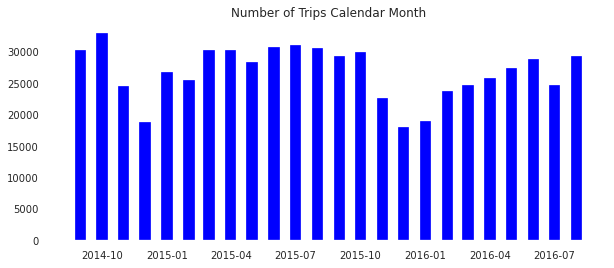

In [39]:
plt.bar('month', 'trips', data =df_longitudinal, color = "blue", width = 16)
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.title('Number of Trips Calendar Month')

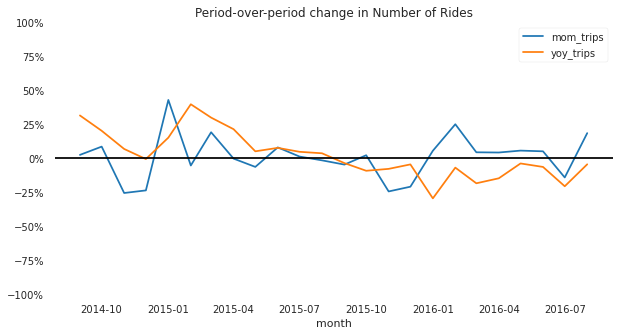

In [112]:
lon = df_longitudinal[['month','mom_trips','yoy_trips']]
lon = lon.set_index('month')
lon.plot()
plt.axhline(0, color = 'black')
plt.ylim((-1, 1)) 
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.title('Period-over-period change in Number of Rides')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


At first it seemed like bad weather in winter months may be the primary cause of the decline, but looking at YoY it seems like there's more to the story. January 2016 was down 20% over January 2015. The volatility of YoY comparisons indicates there may be more happening than a simple seasonal trend. It's also possible that the small numbers are increasing the volatility of these trends. Perhaps exceptional weather, changes in number of workdays during the holidays, cost of travel impacting travelers.. many hypotheses that I would want to dig into if I had more data / time. 

## Q2: Do certain stations run out of bikes? If so, when, and for how long?

In [153]:
stations_without_bikes = """ WITH
RECORDS AS (
    SELECT 
      station_id,
      bikes_available,
      time,
      LAG(bikes_available) OVER (PARTITION BY station_id ORDER BY time) AS last_bikes_available,
      FIRST_VALUE(time) OVER (PARTITION BY station_id ORDER BY time) AS first_timestamp_for_station,
      LAG(time) OVER (PARTITION BY station_id ORDER BY time) AS last_time
    FROM  `bigquery-public-data.san_francisco.bikeshare_status`
    )
    
,  CHANGE_RECORDS AS (
    SELECT 
      station_id,
      FORMAT_DATE("%A" , DATE(time)) AS day_of_week,
      EXTRACT(HOUR FROM time) AS hour_of_day,
      time,
      last_time,
      bikes_available - last_bikes_available AS change_bikes_available,
      TIMESTAMP_DIFF(time,last_time,SECOND) AS seconds_until_bike
    FROM RECORDS
    WHERE 1=1
      AND bikes_available != last_bikes_available 
      AND last_bikes_available = 0
      AND last_bikes_available IS NOT NULL
      AND time != first_timestamp_for_station
      AND last_time IS NOT NULL
  )
# 3 Million records with changes in bikes in a station
# but less than 100 records where a station had no bike for more than 2 minutes
SELECT 
# exclude records where the docks were empty for two minutes or less
  SUM(IF(TIMESTAMP_DIFF(time,last_time,SECOND) > 120,1,0)) AS sessionized_events,
  COUNT(*) AS events
FROM CHANGE_RECORDS
"""
stations_without_bikes_df = client.query(stations_without_bikes).to_dataframe()
print(stations_without_bikes_df)

   sessionized_events  events
0                  77   28032


* if the dock change events are sessionized, there are less than 100 instances of docks without any bikes for more than 2 minutes
* there are 28k+ events if we do not sessionize

Unless there are multiple riders looking for bikes at a station (could look into this with more time and user data) simultaneously, then the time when there are zero bikes at a station are minimal.

## Question 3: Where are the stations located across the Bay Area? Weight by rides by station.
* Assume it's possible for someone to drop off and return a bike at the same location because we're looking for trends beyond commute times
* Use start_date for start_station_id and end_date for end_station_id
* Use data for every day of the week, month, and year

In [115]:
stations = """
WITH 
  UNIQUE_RIDES AS (
    SELECT
        start_station_id AS station_id,
        longitude, 
        latitude,
        start_station_name AS station_name,
        trip_id
      FROM  `bigquery-public-data.san_francisco.bikeshare_trips` bt
      LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bs
        ON bt.start_station_id = bs.station_id
      WHERE  
        TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 2 AND 180

    UNION DISTINCT

    SELECT
        end_station_id AS station_id,
        longitude, 
        latitude,
        end_station_name AS station_name,
        trip_id
      FROM  `bigquery-public-data.san_francisco.bikeshare_trips` bt
      LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bs
        ON bt.end_station_id = bs.station_id
      WHERE  
        TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 2 AND 180
        
    )
SELECT 
  COUNT(DISTINCT trip_id) AS trips,
  station_id,
  longitude, 
  latitude,
  station_name
FROM UNIQUE_RIDES
GROUP BY 
  station_id,
  longitude, 
  latitude,
  station_name
;
"""

rides_by_station_df = client.query(stations).to_dataframe()
rides_by_station_df.head()

,trips,station_id,longitude,latitude,station_name
0,222,83,-122.236234,37.491269,Mezes
1,5615,9,-121.894715,37.348742,Japantown
2,594,83,-122.236234,37.491269,Mezes Park
3,5469,11,-121.885660,37.335885,MLK Library
4,4800,84,-121.895617,37.342725,Ryland Park


In [122]:
fig = gmaps.figure()
starting_station_heatmap_layer = gmaps.heatmap_layer(
    rides_by_station_df[['latitude', 'longitude']], weights=rides_by_station_df['trips'],
    max_intensity=30, point_radius=3.0)


fig.add_layer(starting_station_heatmap_layer)

# prevent dissipation on zoom
gmaps.heatmap_layer.max_intensity = 100
gmaps.heatmap_layer.point_radius = 5

fig

Figure(layout=FigureLayout(height='420px'))

** Looks like there a number of stations in the peninsula and south bay. Do not focus efforts on those. 

## Q4: What is the top route (could have the same start and end point) for Subscribers? Non-Subscribers?
https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html#bicycling-transit-and-traffic-layers

In [123]:
sub_top_routes = """     SELECT 
      start_station_name, st.longitude, st.latitude,
      ST_GeogPoint(st.longitude, st.latitude) AS starting_geo,
      end_station_name,en.longitude AS ending_long, en.latitude AS ending_lat,
      ST_GeogPoint(en.longitude, en.latitude) AS ending_geo,
      COUNT(DISTINCT trip_id) AS trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` t
    LEFT JOIN  `bigquery-public-data.san_francisco.bikeshare_stations` st
      ON t.start_station_id = st.station_id
    LEFT JOIN  `bigquery-public-data.san_francisco.bikeshare_stations` en
      ON t.end_station_id = en.station_id
    WHERE 
      TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 2 AND 180
      AND subscriber_type = 'Subscriber'
    GROUP BY 
      start_station_name, end_station_name, subscriber_type,
       st.longitude, st.latitude,en.longitude, en.latitude
    ORDER BY trips DESC
    LIMIT 1
;"""

sub_top_routes_job = client.query(sub_top_routes) 

sub_top_routes_df = sub_top_routes_job.to_dataframe()

In [124]:
non_sub_top_routes = """     SELECT 
      start_station_name, st.longitude, st.latitude,
      ST_GeogPoint(st.longitude, st.latitude) AS starting_geo,
      end_station_name,en.longitude AS ending_long, en.latitude AS ending_lat,
      ST_GeogPoint(en.longitude, en.latitude) AS ending_geo,
      COUNT(DISTINCT trip_id) AS trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` t
    LEFT JOIN  `bigquery-public-data.san_francisco.bikeshare_stations` st
      ON t.start_station_id = st.station_id
    LEFT JOIN  `bigquery-public-data.san_francisco.bikeshare_stations` en
      ON t.end_station_id = en.station_id
    WHERE 
      TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 2 AND 180
      AND subscriber_type != 'Subscriber'
    GROUP BY 
      start_station_name, end_station_name, subscriber_type,
       st.longitude, st.latitude,en.longitude, en.latitude
    ORDER BY trips DESC
    LIMIT 1
;"""

non_sub_top_routes_job = client.query(non_sub_top_routes) 

non_sub_top_routes_df = non_sub_top_routes_job.to_dataframe()

In [125]:
# sf_coordinates = (37.7749, -122.4194)
# fig = gmaps.figure(center=sf_coordinates, zoom_level=13)
# fig.add_layer(gmaps.bicycling_layer())

In [127]:
# Subscriber start and ending lat/long
s_lat = sub_top_routes_df._get_value(0,'latitude')
s_long = sub_top_routes_df._get_value(0,'longitude')
e_lat = sub_top_routes_df._get_value(0,'ending_lat')
e_long = sub_top_routes_df._get_value(0,'ending_long')

# Non-Subscriber starting and ending lat/long
n_s_lat = non_sub_top_routes_df._get_value(0,'latitude')
n_s_long = non_sub_top_routes_df._get_value(0,'longitude')
n_e_lat = non_sub_top_routes_df._get_value(0,'ending_lat')
n_e_long = non_sub_top_routes_df._get_value(0,'ending_long')


In [129]:
sf_coordinates = (37.7749, -122.4194)

fig = gmaps.figure(center=sf_coordinates, zoom_level=11)

subscriber = gmaps.directions_layer((s_lat, s_long), (e_lat, e_long),
                                          show_markers = False, stroke_color = 'red',
                                          stroke_weight = 3.0, stroke_opacity = 1.0,\
                                          travel_mode = 'BICYCLING')

non_subscriber = gmaps.directions_layer((n_s_lat, n_s_long), (n_e_lat, n_e_long),
                                          show_markers = False, stroke_color = 'blue',
                                          stroke_weight = 3.0, stroke_opacity = 1.0,\
                                          travel_mode = 'BICYCLING')


In [130]:
fig.add_layer(subscriber)
fig.add_layer(non_subscriber)
locations = [
        (s_lat, s_long), (e_lat, e_long),
        (n_s_lat, n_s_long), (n_e_lat, n_e_long),
    ]
marker_layer = gmaps.marker_layer(
        locations,
        hover_text=['Sub. Start', 'Sub. End', 'Non-Sub. Start', 'Non-Sub. End']
    )
marker_layer.markers[0].label = 'Sub. Start'
marker_layer.markers[1].label = 'Sub. End'
marker_layer.markers[2].label = 'Non-Sub. Start'
marker_layer.markers[3].label = 'Non-Sub. End'
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(height='420px'))

* Top routes for subscribers and non-subscribers are different. This likely indicates a different type of rider with different features.

## Q5: What is the share riders attributed to subscribers vs non over time? 

In [ ]:
query_trips_over_time_with_sub = """

WITH 
MONTH_TRIP AS (
  SELECT
    DATE_TRUNC(DATE(start_date), MONTH) AS month,
    COUNT(DISTINCT IF(subscriber_type = 'Subscriber', trip_id, NULL))/ COUNT(DISTINCT trip_id) AS subscriber_trips 
  FROM  `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE TIMESTAMP_DIFF(end_date, start_date, MINUTE) BETWEEN 2 AND 180
  GROUP BY 1
  )
, OVER_TIME AS (
SELECT 
  month,
  subscriber_trips,
  # checked data
  subscriber_trips/LAG(subscriber_trips) OVER (ORDER BY month)-1 AS mom_trips, 
  subscriber_trips/LAG(subscriber_trips,12) OVER (ORDER BY month)-1 AS yoy_trips
FROM MONTH_TRIP
)

SELECT * 
FROM OVER_TIME
WHERE month > '2014-08-01'
;
"""
query_trips_over_time_sub_job = client.query(query_trips_over_time_with_sub) 

df_longitudinal_sub = query_trips_over_time_sub_job.to_dataframe()
df_longitudinal_sub.head()

In [ ]:
plt.bar('month', 'subscriber_trips', data =df_longitudinal_sub, color = "blue", width = 16)
plt.figure(figsize=(30,5)) 

# Share of total hasn't shifted enough over time to indicate a large shift. Focus on subscriber rides

## Q6: What are the busiest days of the week? Times of day?

In [150]:
day_of_week_volume = """
WITH RIDES_BY_DAY AS (
  SELECT 
    DATE(start_date) AS date,
    COUNT(DISTINCT IF( subscriber_type = 'Subscriber', trip_id, NULL)) AS total_subscriber_trips,
    COUNT(DISTINCT trip_id) AS total_trips
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  GROUP BY 1
  )
SELECT 
  FORMAT_DATE("%A" , date) AS day_of_week,
  ROUND(AVG(total_subscriber_trips),0) AS avg_sub_trips_day,
  ROUND(AVG(total_trips),0) AS avg_total_trips_day
FROM RIDES_BY_DAY
GROUP BY 1
ORDER BY 2 desc
;
"""
day_of_week_volume_df = client.query(day_of_week_volume).to_dataframe()
print(day_of_week_volume_df)



time_of_day_volume = """
WITH RIDES_BY_DAY AS (
  SELECT 
    EXTRACT(HOUR FROM start_date) hour,
    COUNT(DISTINCT IF( subscriber_type = 'Subscriber', trip_id, NULL)) AS total_subscriber_trips,
    COUNT(DISTINCT trip_id) AS total_trips
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  GROUP BY 1
  )
SELECT 
  hour,
  ROUND(AVG(total_subscriber_trips),0) AS avg_sub_trips_day,
  ROUND(AVG(total_trips),0) AS avg_total_trips_day
FROM RIDES_BY_DAY
GROUP BY 1
ORDER BY 2 desc
;
"""
time_of_day_volume_df = client.query(time_of_day_volume).to_dataframe()
print(time_of_day_volume_df)

  day_of_week  avg_sub_trips_day  avg_total_trips_day
0     Tuesday             1081.0               1175.0
1   Wednesday             1054.0               1151.0
2    Thursday             1021.0               1127.0
3      Monday              986.0               1082.0
4      Friday              892.0               1019.0
5    Saturday              198.0                384.0
6      Sunday              162.0                327.0
    hour  avg_sub_trips_day  avg_total_trips_day
0      8           127171.0             132464.0
1     17           114915.0             126302.0
2      9            89546.0              96118.0
3     16            76051.0              88755.0
4     18            75798.0              84569.0
5      7            64946.0              67531.0
6     19            35515.0              41071.0
7     15            34820.0              47626.0
8     10            34532.0              42782.0
9     12            34442.0              46950.0
10    13            30995.0  

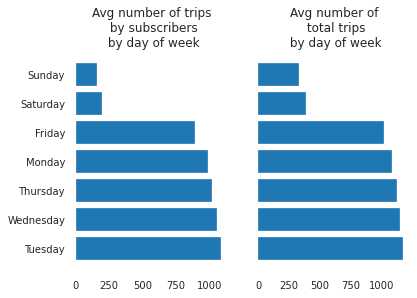

In [149]:
fig, ax = plt.subplots(1,2, sharey = True)
ax[0].barh(day_of_week_volume_df.day_of_week, day_of_week_volume_df.avg_sub_trips_day, align='center')
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_title('Avg number of trips\n by subscribers\n by day of week')

ax[1].barh(day_of_week_volume_df.day_of_week, day_of_week_volume_df.avg_total_trips_day, align='center')
ax[1].invert_yaxis()  # labels read top-to-bottom
ax[1].set_title('Avg number of\n total trips\n by day of week')


plt.show()

* Most rides are on weekdays. Very few on weekends.

* Recommendation: To increase rides - look for opportunities to appeal to leisure riders (e.g., those on weekends.) Since non-subscribers may be more likely to ride on tourist routes, consider whether there needs to be a capacity shift for weekends.